# REDBACK OPERATIONS | ELDERLY WEARABLE TECHNOLOGY
### RHYTHM NARULA | S223770022@DEAKIN.EDU.AU

# Fall Detection for Elderly Wearable Tech
Falls are one of the leading causes of injury in elderly populations. Detecting falls in real time can greatly shorten response time and minimise long-term damage. This research intends to create a fall detection model based on data from wearable sensors (accelerometers and gyroscopes) that are part of an ageing monitoring system. The model will classify falls using sensor data, giving a dependable solution for real-world use.

The major purpose of this project is to develop a deep learning model that can accurately distinguish between falls and non-falls. The model tries to increase prediction accuracy by using time-series data from accelerometers and gyroscopes while addressing issues such as data imbalance and noise.

### Data Collection and Preparation
####  Data Sources
The dataset used in this project consists of time-series data collected from wearable devices, specifically accelerometer and gyroscope sensors. The sensors operate at a frequency of 50Hz, capturing detailed motion data. The data contains multiple fall scenarios along with routine movements, which helps in training the model to recognize fall patterns.
#### Data Merging and Cleaning
To combine the accelerometer and gyroscope data, the datasets were merged on the timestamp for each activity. Gyroscope time lists were discarded to avoid redundancy, and missing values were carefully handled by removing NaNs, ensuring data integrity for the model.

In [13]:
import os
import pandas as pd
import numpy as np

# Function to merge accel and gyro data
def merge_data(accel_file, gyro_file):
    accel_data = pd.read_csv(accel_file)
    gyro_data = pd.read_csv(gyro_file)
    merged_data = pd.concat([accel_data, gyro_data.drop(columns=['gyro_time_list'])], axis=1)  # drop gyro_time_list
    return merged_data

# Function to label the merged data based on timestamps
def apply_labels(merged_data, filename, fall_timestamps):
    # Filter rows for the current filename
    file_timestamps = fall_timestamps[fall_timestamps['filename'] == filename]

    # Initialize the labels column with 0
    merged_data['labels'] = 0

    # Loop through each timestamp entry for this file
    for _, row in file_timestamps.iterrows():
        start_time = row['start_time']
        end_time = row['end_time']

        # Assign label 1 if accel_time_list falls within the start_time and end_time
        merged_data.loc[(merged_data['accel_time_list'] >= start_time) & (merged_data['accel_time_list'] <= end_time), 'labels'] = 1

    return merged_data

# Load the fall timestamps data
fall_timestamps_path = '/path/to/dataset/fall_timestamps.csv'
fall_timestamps = pd.read_csv(fall_timestamps_path)

# Base directory containing F01, F02, ... folders
base_dir = '/path/to/dataset/50hz/'
# Prepare to store all merged data with user and fall information
all_data = []

# Iterate over F01, F02, ..., F08 folders only
for folder in os.listdir(base_dir):
    if folder.startswith('F'):  # Ensure we are working only on F folders (fall types)
        folder_path = os.path.join(base_dir, folder)

        # Extract the fall type from the folder name (e.g., F01)
        fall_type = folder

        # Iterate over the files in each folder
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if 'accel.csv' in file:
                    # Identify corresponding gyro file
                    gyro_file = file.replace('accel.csv', 'gyro.csv')
                    
                    accel_file_path = os.path.join(root, file)
                    gyro_file_path = os.path.join(root, gyro_file)
                    
                    if os.path.exists(gyro_file_path):
                        # Merge accel and gyro data
                        merged_data = merge_data(accel_file_path, gyro_file_path)
                        
                        # Get the filename format used in the fall_timestamps file (e.g., F01/U01_R01)
                        filename = f"{folder}/{file.replace('_accel.csv', '')}"
                        
                        # Extract user ID (e.g., U01) from the file name
                        user_id = file.split('_')[0]

                        # Apply labels to the merged data based on the timestamps
                        merged_data = apply_labels(merged_data, filename, fall_timestamps)
                        
                        # Add user and fall type columns to the merged data
                        merged_data['user_id'] = user_id
                        merged_data['fall_type'] = fall_type
                        
                        # Append the merged data to the all_data list
                        all_data.append(merged_data)

                        # Optionally, remove the original files after merging
                        os.remove(accel_file_path)
                        os.remove(gyro_file_path)

print("All files merged and labeled successfully.")

# Step 2: Combine all merged data into one final dataset
final_merged_data = pd.concat(all_data, axis=0)

# Save the final merged dataset to a CSV file
final_output_path = '/path/to/output/final_merged_dataset_with_users_fall.csv'
final_merged_data.to_csv(final_output_path, index=False)
print("Final merged dataset saved with user and fall type information.")

All files merged and labeled successfully.
Final merged dataset saved with user and fall type information.


### Data Cleaning and NaN Handling & Reshaping
After merging the data, any rows containing NaN values are removed to ensure that the model is trained on valid data only.

#### Data Reshaping
The sensor data is reshaped into fixed time steps of 500 to fit the CNN input format. Each sample is a time-series window of 500 steps and contains 6 features (3 from the accelerometer and 3 from the gyroscope).

In [15]:
# Load the final merged dataset
final_merged_dataset = pd.read_csv(final_output_path)

# Define the features (sensor data) and labels (fall or non-fall)
sensor_data = final_merged_dataset[['accel_x_list', 'accel_y_list', 'accel_z_list', 'gyro_x_list', 'gyro_y_list', 'gyro_z_list']].values
labels = final_merged_dataset['labels'].values

# Reshape the sensor data to fit into the CNN model
TIME_STEPS = 500  # 500 time steps per sample
FEATURES = 6  # 6 sensor features (accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z)

# Function to reshape data
def reshape_for_cnn(data, time_steps):
    num_samples = len(data) // time_steps
    data = data[:num_samples * time_steps]
    return data.reshape(num_samples, time_steps, FEATURES)

X = reshape_for_cnn(sensor_data, TIME_STEPS)
y = labels[:X.shape[0]]

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (scale)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Check for NaN values and remove them
print(f"NaN values in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"NaN values in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

X_train_scaled_clean = X_train_scaled[~np.isnan(X_train_scaled).any(axis=(1, 2))]
y_train_clean = y_train[~np.isnan(X_train_scaled).any(axis=(1, 2))]

X_test_scaled_clean = X_test_scaled[~np.isnan(X_test_scaled).any(axis=(1, 2))]
y_test_clean = y_test[~np.isnan(X_test_scaled).any(axis=(1, 2))]

# Display the final shapes of the cleaned datasets
print(f"Shape after cleaning - X_train: {X_train_scaled_clean.shape}, y_train: {y_train_clean.shape}")
print(f"Shape after cleaning - X_test: {X_test_scaled_clean.shape}, y_test: {y_test_clean.shape}")


NaN values in X_train_scaled: 366
NaN values in X_test_scaled: 102
Shape after cleaning - X_train: (201, 500, 6), y_train: (201,)
Shape after cleaning - X_test: (49, 500, 6), y_test: (49,)


### Time-Series Plot of Accelerometer and Gyroscope Data

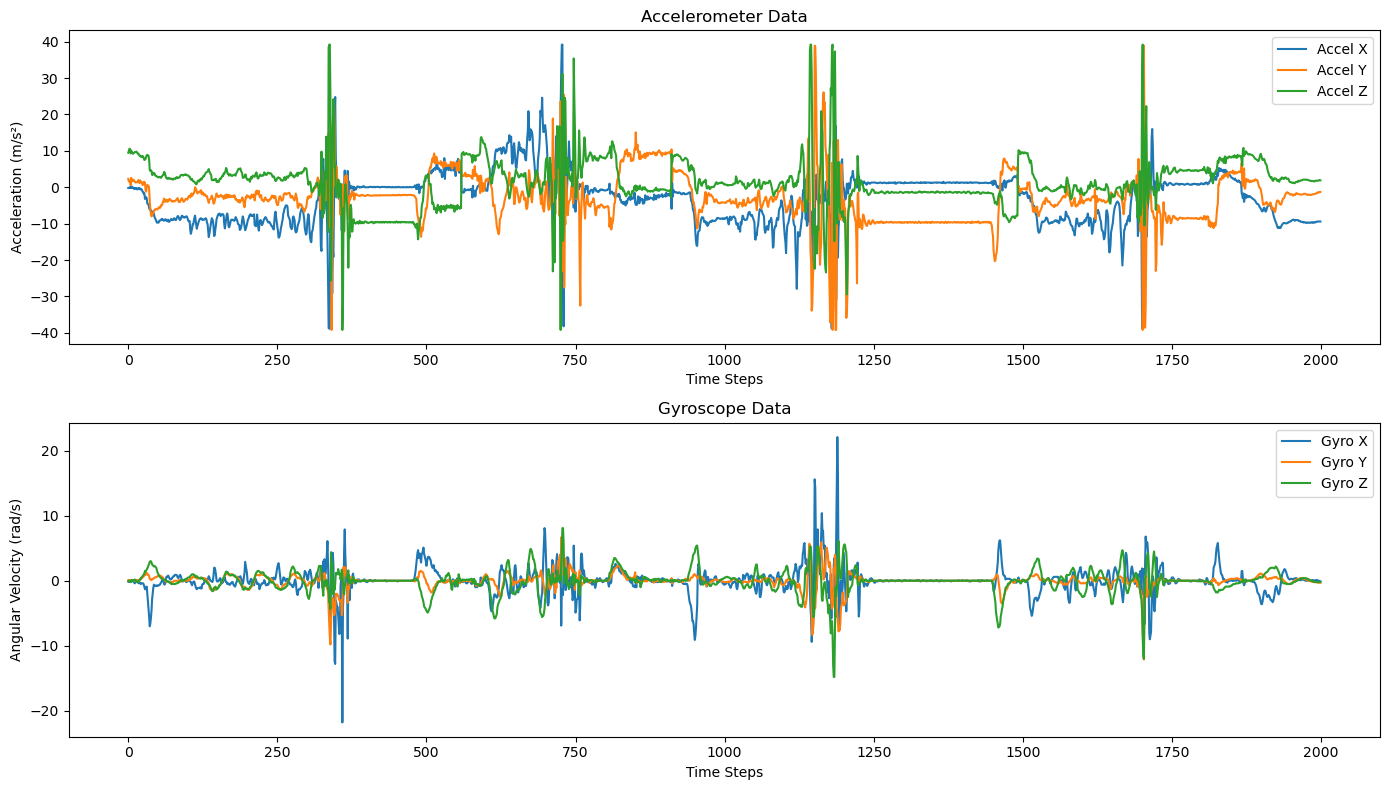

In [17]:
import matplotlib.pyplot as plt

# Select a small portion of the dataset for visualization (e.g., first 2000 samples)
sample_data = final_merged_dataset.iloc[:2000]

# Plot accelerometer data
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(sample_data['accel_x_list'], label='Accel X')
plt.plot(sample_data['accel_y_list'], label='Accel Y')
plt.plot(sample_data['accel_z_list'], label='Accel Z')
plt.title('Accelerometer Data')
plt.xlabel('Time Steps')
plt.ylabel('Acceleration (m/s²)')
plt.legend()

# Plot gyroscope data
plt.subplot(2, 1, 2)
plt.plot(sample_data['gyro_x_list'], label='Gyro X')
plt.plot(sample_data['gyro_y_list'], label='Gyro Y')
plt.plot(sample_data['gyro_z_list'], label='Gyro Z')
plt.title('Gyroscope Data')
plt.xlabel('Time Steps')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()


* The first subplot depicts the accelerometer data (x, y, and z axes), displaying the body movements in various directions.
* The second subplot displays the gyroscope data (x, y, and z axes), which captures rotational motion.
* This visualisation can aid in detecting potential trends or spikes in sensor readings during falls versus non-falls.

### Data Preprocessing and Model Setup

#### Data Augmentation and Class Weighting
To address the class imbalance, we compute class weights and use data augmentation by adding noise to the training data.

In [19]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to address imbalance in the dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_clean), y=y_train_clean.flatten())
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Add noise to the training data for data augmentation
noise_factor = 0.1
X_train_noisy = X_train_scaled_clean + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_scaled_clean.shape)
X_train_noisy = np.clip(X_train_noisy, -1., 1.)  # Ensure values remain within [-1, 1] range

# Combine original and noisy data
X_train_augmented = np.vstack([X_train_scaled_clean, X_train_noisy])
y_train_augmented = np.concatenate([y_train_clean, y_train_clean])

print(f"Shape of augmented training data: {X_train_augmented.shape}")


Shape of augmented training data: (402, 500, 6)


### Convolutional neural networks (CNN)
Given the time-series nature of the data, a Convolutional Neural Network (CNN) was used for this project. CNNs are good at detecting spatial patterns in sequential data, which makes them perfect for spotting fall patterns from sensor measurements.

To avoid overfitting, the architecture contains numerous convolutional layers that use batch normalisation and dropout. Dropout layers are especially significant because of the inherent noise and volatility in real-world sensor data.


#### Model Training
The model is trained using early stopping and a learning rate reduction when the validation loss plateaus. We also add noise to the training data to improve model generalization.

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization, Flatten, Dense

# Build the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, FEATURES)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_augmented, y_train_augmented, epochs=20, batch_size=32, validation_data=(X_test_scaled_clean, y_test_clean), callbacks=[reduce_lr, early_stopping], class_weight=class_weight_dict)



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3493 - loss: 1.2471 - val_accuracy: 0.6735 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5756 - loss: 0.8842 - val_accuracy: 0.7551 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6301 - loss: 0.7200 - val_accuracy: 0.6939 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7872 - loss: 0.3684 - val_accuracy: 0.6531 - val_loss: 0.5761 - learning_rate: 0.0010
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8458 - loss: 0.2567 - val_accuracy: 0.6735 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8712 - loss: 0.1876 - val_accuracy: 0.6735 - val_loss: 0.5947 - learning_rate: 0.0010
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9132 - loss: 0.2149 - val_accuracy

### Results and Evaluation
#### Training and Validation Accuracy and Loss
Below are the plots showing the training and validation accuracy and loss over 20 epochs.

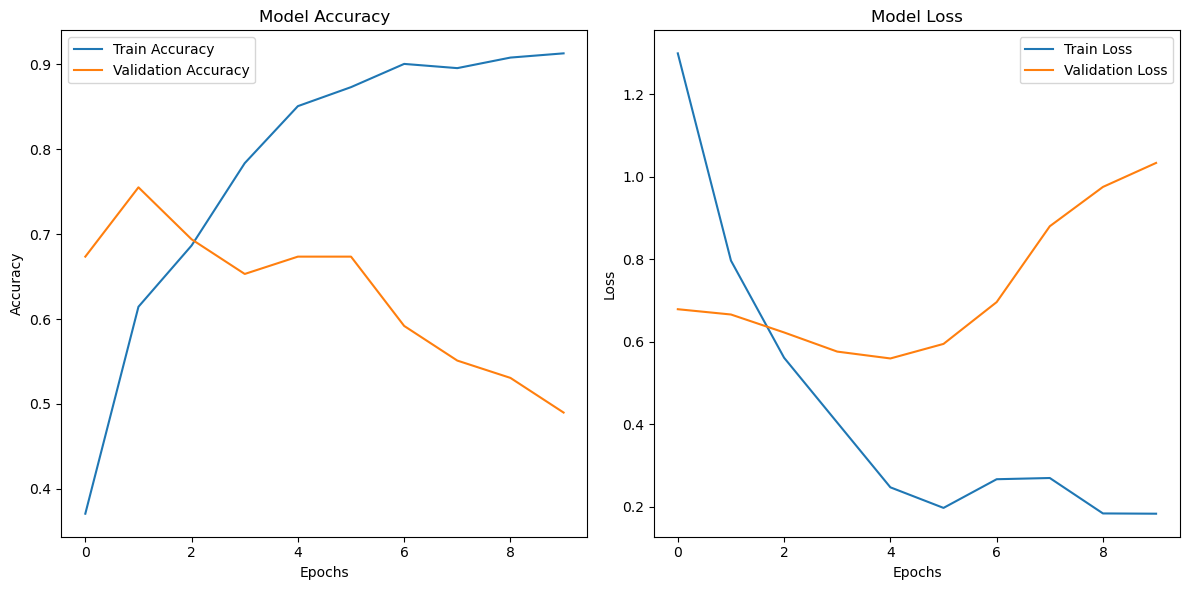

Final training accuracy: 0.9129353165626526
Final validation accuracy: 0.4897959232330322


In [25]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Display final training and validation accuracy
print(f"Final training accuracy: {history.history['accuracy'][-1]}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]}")



The model achieved an impressive training accuracy of 91.29%, indicating that the CNN effectively learned patterns within the training data. However, the validation accuracy plateaued at 48.98%, revealing a significant gap between the training and validation performance. This discrepancy suggests that the model might be overfitting to the training data, making it less capable of generalizing to unseen data.



### Conclusion.
* The deep learning model developed for fall detection showed strong training performance, achieving a final training accuracy of 91.29% over 20 epochs. However, the validation accuracy plateaued at 48.98%, suggesting the model may have overfitted to the training data. Despite this, the model demonstrated its ability to learn patterns from the data effectively, but further steps are required to improve generalization to unseen data.

* This performance plateau indicates that, while the model may effectively learn patterns from the data, additional steps are required to improve its generalisation to new, unseen data. Additional data augmentation, hyperparameter fine-tuning, increased regularisation (e.g., dropout or L2 regularisation), and experimenting with more complex model architectures (such as adding more layers or using recurrent networks) could all help to improve the model's accuracy.

* Furthermore, expanding the dataset or including more diverse fall scenarios could offer the model with more training data, allowing it to generalise more effectively in real-world applications. Overall, this project lays a solid foundation for fall detection in wearable technology, and with future refining, it has the potential to become a highly accurate and dependable system for real-time monitoring of the elderly.

### Future Work 
Data Augmentation: Future work could explore more advanced data augmentation techniques such as time-warping or rotation for time-series data.
Real-time Deployment: The methodology could be tailored for real-time deployment in IoT contexts that require quick detection and action.